In [1]:
import sys
sys.path.insert(0, '../../../../fastshap_tf/')
from fastshap import ResizeMask

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [2]:
import pickle
import numpy as np

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

from datetime import datetime
import os

In [4]:
from tensorflow.keras.layers import (Input, Layer, Dense, Lambda, 
                                     Dropout, Multiply, BatchNormalization, 
                                     Reshape, Concatenate, Conv2D, Permute)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications.resnet50 import ResNet50

In [5]:
import pandas as pd
from functools import reduce

In [6]:
# IMPORTANT: SET RANDOM SEEDS FOR REPRODUCIBILITY
os.environ['PYTHONHASHSEED'] = str(420)
import random
random.seed(420)
np.random.seed(420)

In [7]:
#################### Load Images + Predictions ####################
images_dir = os.path.join('../', 'images')
images = np.load(os.path.join(images_dir, 'processed_images.npy'), allow_pickle=True)


preds_path = os.path.join(images_dir, 'predictions.npy')
preds = np.load(preds_path, allow_pickle=True)
preds_discrete = np.eye(10)[preds.argmax(1)]

In [8]:
#################### Load Evaluator Model ####################
class Random_Bernoulli_Sampler(Layer):
    '''
    Layer to Sample r
    '''
    def __init__(self, num_features, **kwargs):
        super(Random_Bernoulli_Sampler, self).__init__(**kwargs)
        
        self.num_features = num_features
        
        
    def call(self,  logits):
        batch_size = tf.shape(logits)[0]
        
        u = tf.random.uniform(shape=(batch_size, self.num_features),
                                    minval=np.finfo(
                                        tf.float32.as_numpy_dtype).tiny,
                                    maxval=1.0) 

        r = K.cast(tf.stop_gradient(u > 0.5), tf.float32)
        
        return r

    
INPUT_SHAPE = (224,224,3)
base_model = ResNet50(
    include_top=False, weights='imagenet', 
    input_shape=INPUT_SHAPE, pooling='avg'
)
base_model.trainable = True

model_input = Input(shape=INPUT_SHAPE, dtype='float32', name='input')
R = Random_Bernoulli_Sampler(14*14)(model_input)
R = ResizeMask(in_shape=INPUT_SHAPE, mask_size=14*14)(R)
xr = Multiply()([model_input, R])

net = base_model(xr)
out = Dense(10, activation='softmax')(net)

evaluator_model = Model(model_input, out)

evaluator_weights = 'evaluator/model_weights.h5'
evaluator_model.load_weights(evaluator_weights)
evaluator_model = Sequential(   
            [l for l in evaluator_model.layers[-2:]]
        )
evaluator_model.trainable = False

OPTIMIZER = tf.keras.optimizers.Adam(1e-3)
METRICS = [ 
  tf.keras.metrics.AUC(name='auroc'),
  tf.keras.metrics.AUC(curve='PR', name='auprc'),
  tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='accuracy'),
]

evaluator_model.compile(
    loss='categorical_crossentropy',
    optimizer=OPTIMIZER,
    metrics=METRICS,
)

# Run Evaluations for Each Method and Masking Percent

In [10]:
def log_odds(p):
    p = np.clip(p, 0.0001, 0.9999)
    return np.log(p/(1-p))

In [11]:
methods = ['fastshap', 'kernelshap', 'kernelshap_plus', 'gradcam', 'integratedgradients', 'smoothgrad', 'deepshap']
for method in methods:
    print(method)
    evaluation_results = {}
    
    #################### Load Masks ####################
    if method in ['gradcam', 'integratedgradients', 'smoothgrad','deepshap']:
        method_dir = os.path.join('../', method) 
    else:
        method_dir = os.path.join('../', method, 'results')
    
    with open(os.path.join(method_dir, 'masks.pkl'), 'rb') as f:
        mask_dict = pickle.load(f)
    
    evaluation_results['acc'] = {}
    evaluation_results['auroc'] = {}
    evaluation_results['auprc'] = {}
    evaluation_results['preds'] = {} 
    evaluation_results['delta_lo'] = {}
    for p, masks in mask_dict.items():
        #################### Mask Images ####################
        if len(masks.shape) < 4:
            masks = np.expand_dims(masks, -1)
        masked_images = images * masks

        #################### Evaluate Masked Images ####################
        _, auroc, auprc, acc = evaluator_model.evaluate(x = masked_images, 
                                                        y = preds_discrete)
        masked_preds = evaluator_model.predict(masked_images)
        delta_lo = np.mean(log_odds(preds[preds_discrete==1]) - 
                           log_odds(masked_preds[preds_discrete==1]))
        
        evaluation_results['acc'][p] = acc
        evaluation_results['auroc'][p] = auroc
        evaluation_results['auprc'][p] = auprc
        evaluation_results['preds'][p] = masked_preds
        evaluation_results['delta_lo'][p] = delta_lo
    
    #################### Save ####################
    with open(os.path.join(method_dir, 'evaluation_results_out.pkl'), 'wb') as f:
        pickle.dump(evaluation_results, f)

fastshap
32/32 [==============================] - 1s 33ms/step - loss: 3.1793 - auroc: 0.5204 - auprc: 0.1059 - accuracy: 0.1000
kernelshap
32/32 [==============================] - 1s 34ms/step - loss: 3.1542 - auroc: 0.5232 - auprc: 0.1119 - accuracy: 0.1070
kernelshap_plus
32/32 [==============================] - 1s 33ms/step - loss: 3.1733 - auroc: 0.5102 - auprc: 0.1021 - accuracy: 0.1050
gradcam
32/32 [==============================] - 1s 34ms/step - loss: 3.1611 - auroc: 0.5213 - auprc: 0.1074 - accuracy: 0.1040
integratedgradients
32/32 [==============================] - 1s 34ms/step - loss: 3.1455 - auroc: 0.5254 - auprc: 0.1093 - accuracy: 0.1010
smoothgrad
32/32 [==============================] - 1s 33ms/step - loss: 3.1548 - auroc: 0.5267 - auprc: 0.1084 - accuracy: 0.1050
deepshap
32/32 [==============================] - 1s 33ms/step - loss: 3.1020 - auroc: 0.5334 - auprc: 0.1114 - accuracy: 0.1140


In [15]:
methods = ['fastshap', 'kernelshap', 'kernelshap_plus', 'gradcam', 'integratedgradients', 'smoothgrad', 'deepshap']
for method in methods:
    print(method)
    evaluation_results = {}
    
    #################### Load Masks ####################
    if method in ['gradcam', 'integratedgradients', 'smoothgrad','deepshap']:
        method_dir = os.path.join('../', method) 
    else:
        method_dir = os.path.join('../', method, 'results')
    
    with open(os.path.join(method_dir, 'masks_in.pkl'), 'rb') as f:
        mask_dict = pickle.load(f)
    
    evaluation_results['acc'] = {}
    evaluation_results['auroc'] = {}
    evaluation_results['auprc'] = {}
    evaluation_results['preds'] = {} 
    evaluation_results['delta_lo'] = {}
    for p, masks in mask_dict.items():
        #################### Mask Images ####################
        if len(masks.shape) < 4:
            masks = np.expand_dims(masks, -1)
        masked_images = images * masks

        #################### Evaluate Masked Images ####################
        _, auroc, auprc, acc = evaluator_model.evaluate(x = masked_images, 
                                                        y = preds_discrete)
        
        masked_preds = evaluator_model.predict(masked_images)
        delta_lo = np.mean(log_odds(preds[preds_discrete==1]) - 
                           log_odds(masked_preds[preds_discrete==1]))
        
        evaluation_results['acc'][p] = acc
        evaluation_results['auroc'][p] = auroc
        evaluation_results['auprc'][p] = auprc
        evaluation_results['preds'][p] = masked_preds
        evaluation_results['delta_lo'][p] = delta_lo
    
    #################### Save ####################
    with open(os.path.join(method_dir, 'evaluation_results_in.pkl'), 'wb') as f:
        pickle.dump(evaluation_results, f)

fastshap
32/32 [==============================] - 1s 34ms/step - loss: 0.5496 - auroc: 0.9786 - auprc: 0.9126 - accuracy: 0.8390
kernelshap
32/32 [==============================] - 1s 34ms/step - loss: 0.5532 - auroc: 0.9781 - auprc: 0.9109 - accuracy: 0.8420
kernelshap_plus
32/32 [==============================] - 1s 33ms/step - loss: 0.5373 - auroc: 0.9803 - auprc: 0.9162 - accuracy: 0.8390
gradcam
32/32 [==============================] - 1s 34ms/step - loss: 0.5547 - auroc: 0.9785 - auprc: 0.9119 - accuracy: 0.8350
integratedgradients
32/32 [==============================] - 1s 34ms/step - loss: 0.5534 - auroc: 0.9790 - auprc: 0.9145 - accuracy: 0.8360
smoothgrad
32/32 [==============================] - 1s 34ms/step - loss: 0.5558 - auroc: 0.9789 - auprc: 0.9130 - accuracy: 0.8370
deepshap
32/32 [==============================] - 1s 34ms/step - loss: 0.5505 - auroc: 0.9781 - auprc: 0.9122 - accuracy: 0.8390


# Graph Degradation

In [ ]:
results_dir = 'results'
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

### Load Results

In [12]:
all_results_out = {}
for method in methods:

    if method in ['gradcam', 'integratedgradients', 'smoothgrad','deepshap']:
        method_dir = os.path.join('../', method) 
    else:
        method_dir = os.path.join('../', method, 'results')
    
    with open(os.path.join(method_dir, 'evaluation_results_out.pkl'), 'rb') as f:
        evaluation_results = pickle.load(f)
    
    all_results_out[method] = evaluation_results

In [14]:
for method in methods:
    print(method)
    print(all_results_out[method]['delta_lo'])

fastshap
{'1': 2.6404269, '5': 3.132477, '10': 3.8792753, '15': 4.610126, '25': 5.9523687, '50': 8.199229, '75': 9.402236, '85': 9.656608, '90': 9.747093, '95': 9.882235, '99': 10.047526}
kernelshap
{'1': 2.663361, '5': 2.7910776, '10': 2.9157057, '15': 3.0502386, '25': 3.3783252, '50': 4.5734444, '75': 6.5304475, '85': 7.773339, '90': 8.462822, '95': 9.301437, '99': 10.015924}
kernelshap_plus
{'1': 2.6975603, '5': 2.9949255, '10': 3.254838, '15': 3.4775972, '25': 3.9746776, '50': 5.56981, '75': 8.090187, '85': 9.124062, '90': 9.524071, '95': 9.740734, '99': 10.044406}
gradcam
{'1': 2.6470742, '5': 2.996159, '10': 3.4585373, '15': 3.8954542, '25': 4.6884656, '50': 6.3318515, '75': 7.7227793, '85': 8.589229, '90': 9.028724, '95': 9.557494, '99': 10.028272}
integratedgradients
{'1': 2.6092846, '5': 2.7925684, '10': 3.0708566, '15': 3.445579, '25': 4.2623363, '50': 6.299312, '75': 8.110403, '85': 8.759514, '90': 9.119705, '95': 9.563286, '99': 10.011738}
smoothgrad
{'1': 2.5942774, '5': 2

In [16]:
all_results_in = {}
for method in methods:

    if method in ['gradcam', 'integratedgradients', 'smoothgrad','deepshap']:
        method_dir = os.path.join('../', method) 
    else:
        method_dir = os.path.join('../', method, 'results')
    
    with open(os.path.join(method_dir, 'evaluation_results_in.pkl'), 'rb') as f:
        evaluation_results = pickle.load(f)
    
    all_results_in[method] = evaluation_results

In [17]:
for method in methods:
    print(method)
    print(all_results_in[method]['delta_lo'])

fastshap
{'1': 9.774738, '5': 8.207549, '10': 6.710542, '15': 5.563668, '25': 4.0973215, '50': 2.6934497, '75': 2.4332724, '85': 2.410064, '90': 2.4401228, '95': 2.4941413, '99': 2.5724802}
kernelshap
{'1': 9.753418, '5': 8.158691, '10': 6.5527225, '15': 5.3182144, '25': 3.8985395, '50': 2.6379173, '75': 2.45906, '85': 2.4786866, '90': 2.4819984, '95': 2.5191252, '99': 2.570983}
kernelshap_plus
{'1': 9.659448, '5': 7.4262686, '10': 5.437742, '15': 4.095351, '25': 2.6506655, '50': 1.7600273, '75': 1.9876764, '85': 2.1544564, '90': 2.270924, '95': 2.4052777, '99': 2.5469854}
gradcam
{'1': 9.841398, '5': 8.572016, '10': 7.219049, '15': 6.042665, '25': 4.579821, '50': 3.0978782, '75': 2.614766, '85': 2.5728142, '90': 2.566055, '95': 2.5748377, '99': 2.5859296}
integratedgradients
{'1': 9.84741, '5': 8.5934515, '10': 7.4282117, '15': 6.3523574, '25': 4.8768272, '50': 3.28249, '75': 2.724649, '85': 2.6143625, '90': 2.600459, '95': 2.59765, '99': 2.5849755}
smoothgrad
{'1': 9.886723, '5': 8.9

### Get Bootstrap Delta Log Odds

In [52]:
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm 

#Initialize Dictionary
for method in methods:
    all_results_out[method]['bootstrap_delta_lo'] = {}
    for p in all_results_out[method]['preds'].keys():
        all_results_out[method]['bootstrap_delta_lo'][p] = []

for i in tqdm(range(100)):
    # Get Bootstrap Indices
    inds = np.random.choice(np.arange(1000), 666, replace=False)
    
    for method in methods:
        for p in all_results_out[method]['preds'].keys():
            # Prediction
            masked_preds = all_results_out[method]['preds'][p][inds]
            #Label
            y = preds_discrete[inds]
            y_preds = preds[inds] 
            # Delta Log Odds
            delta_lo = np.mean(log_odds(y_preds[y==1]) - 
                               log_odds(masked_preds[y==1]))
            #Add to Dict
            all_results_out[method]['bootstrap_delta_lo'][p].append(delta_lo)       

  0%|          | 0/100 [00:00<?, ?it/s]

In [53]:
#Initialize Dictionary
for method in methods:
    all_results_in[method]['bootstrap_delta_lo'] = {}
    for p in all_results_in[method]['preds'].keys():
        all_results_in[method]['bootstrap_delta_lo'][p] = []

for i in tqdm(range(100)):
    # Get Bootstrap Indices
    inds = np.random.choice(np.arange(1000), 666, replace=False)
    
    for method in methods:
        for p in all_results_in[method]['preds'].keys():
            # Prediction
            masked_preds = all_results_in[method]['preds'][p][inds]
            #Label
            y = preds_discrete[inds]
            y_preds = preds[inds] 
            # Delta Log Odds
            delta_lo = np.mean(log_odds(y_preds[y==1]) - 
                               log_odds(masked_preds[y==1]))
            #Add to Dict
            all_results_in[method]['bootstrap_delta_lo'][p].append(delta_lo)       

  0%|          | 0/100 [00:00<?, ?it/s]

### Graph

In [54]:
import matplotlib.pyplot as plt

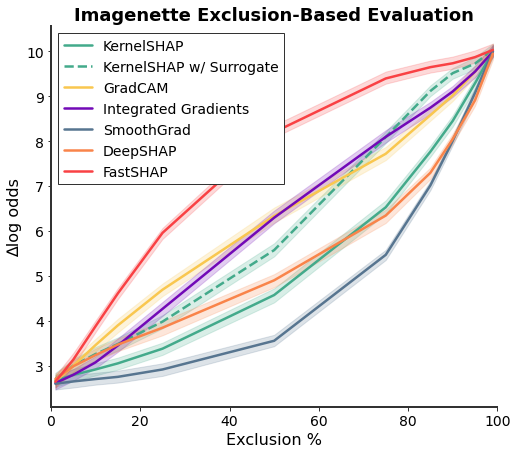

In [55]:
import itertools
method_names = ['FastSHAP', 'KernelSHAP', 'KernelSHAP w/ Surrogate', 'GradCAM', 'Integrated Gradients', 'SmoothGrad', 'DeepSHAP']
accuracy_out = []
for method in methods:
    df =  pd.DataFrame([(int(k), np.mean(v), 
                         np.percentile(v, 5), np.percentile(v, 95)) for k, v in all_results_out[method]['bootstrap_delta_lo'].items()])
    df.columns = ['Exclusion %', method, method+'_lower', method+'_upper']
    accuracy_out.append(df)

accuracy_out = reduce(lambda x, y: pd.merge(x, y, on = 'Exclusion %'), accuracy_out)
accuracy_out.columns = ['Exclusion %'] + list(itertools.chain(*[[x, x+'_lower', x+'_upper'] for x in method_names]))

#### FIGURE #####
colors = {'FastSHAP':'#f94144', 'KernelSHAP':'#43aa8b', 'KernelSHAP w/ Surrogate':'#43aa8b', 
          'GradCAM':'#f9c74f', 'Integrated Gradients':'#7209b7', 
          'SmoothGrad':'#577590', 'DeepSHAP':'#f9844a'}

plt.figure(figsize=(8, 7))
for method in method_names[1:] + ['FastSHAP']:
    if method == 'KernelSHAP w/ Surrogate':
        plt.plot(accuracy_out['Exclusion %'], accuracy_out[method],
                 label=method, color=colors[method], linestyle='--')
    else:
        plt.plot(accuracy_out['Exclusion %'], accuracy_out[method],
                 label=method, color=colors[method])
    plt.fill_between(accuracy_out['Exclusion %'],
                     accuracy_out[method+'_lower'] ,
                     accuracy_out[method+'_upper'],
                     color=colors[method], alpha=0.2)


# plt.ylim(0, 1.)
plt.xlim(0, 100)
plt.legend(fontsize=14)
plt.tick_params(labelsize=14)
plt.ylabel('∆log odds', fontsize=16)
plt.xlabel('Exclusion %', fontsize=16)
plt.title('CIFAR-10 Exclusion-Based Evaluation', fontsize=18)

# plt.savefig(os.path.join(results_dir, 'exclusion-log_odds.jpeg'))
plt.show()

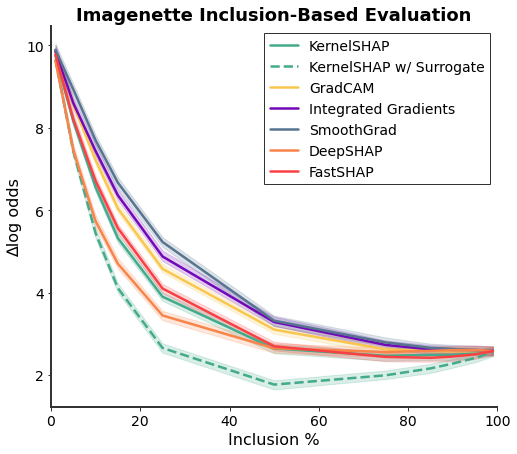

In [56]:
accuracy_in = []
for method in methods:
    df =  pd.DataFrame([(int(k), np.mean(v), 
                         np.percentile(v, 5), np.percentile(v, 95)) for k, v in all_results_in[method]['bootstrap_delta_lo'].items()])
    df.columns = ['Inclusion %', method, method+'_lower', method+'_upper']
    accuracy_in.append(df)

accuracy_in = reduce(lambda x, y: pd.merge(x, y, on = 'Inclusion %'), accuracy_in)
accuracy_in.columns = ['Inclusion %'] + list(itertools.chain(*[[x, x+'_lower', x+'_upper'] for x in method_names]))

plt.figure(figsize=(8, 7))
for method in method_names[1:] + ['FastSHAP']:
    if method == 'KernelSHAP w/ Surrogate':
        plt.plot(accuracy_in['Inclusion %'], accuracy_in[method],
                 label=method, color=colors[method], linestyle='--')
    else:
        plt.plot(accuracy_in['Inclusion %'], accuracy_in[method],
                 label=method, color=colors[method])
    plt.fill_between(accuracy_in['Inclusion %'],
                     accuracy_in[method+'_lower'] ,
                     accuracy_in[method+'_upper'],
                     color=colors[method], alpha=0.2)


# plt.ylim(0, 1.)
plt.xlim(0, 100)
plt.legend(fontsize=14)
plt.tick_params(labelsize=14)
plt.ylabel('∆log odds', fontsize=16)
plt.xlabel('Inclusion %', fontsize=16)
plt.title('CIFAR-10 Inclusion-Based Evaluation', fontsize=18)

# plt.savefig(os.path.join(results_dir, 'inclusion-log-odds.jpeg'))
plt.show()

### AUCs

In [58]:
from sklearn.metrics import auc

for method, name in zip(methods, method_names):
    # Exlcusion
    auc_outs = []
    for i in range(100):
        x = []
        y = []
        for p in all_results_out[method]['bootstrap_delta_lo'].keys():
            x.append(float(p))
            y.append(all_results_out[method]['bootstrap_delta_lo'][p][i])
        auc_outs.append(auc(np.array(x), np.array(y)))
    auc_outs = np.array(auc_outs)/100
    
    # Inclusion
    auc_ins = []
    for i in range(100):
        x = []
        y = []
        for p in all_results_in[method]['bootstrap_delta_lo'].keys():
            x.append(float(p))
            y.append(all_results_in[method]['bootstrap_delta_lo'][p][i])
        auc_ins.append(auc(np.array(x), np.array(y)))
    auc_ins = np.array(auc_ins)/100
    
    # Print
    print('{} & {:.2f} ({:.2f}, {:.2f}) & {:.2f} ({:.2f}, {:.2f})'.format(name, 
                                                                        auc_outs.mean(), 
                                                                        np.percentile(auc_outs, 5), 
                                                                        np.percentile(auc_outs, 95), 
                                                                        auc_ins.mean(), 
                                                                        np.percentile(auc_ins, 5), 
                                                                        np.percentile(auc_ins, 95)))
    
    

FastSHAP & 7.33 (7.23, 7.44) & 3.60 (3.52, 3.70)
KernelSHAP & 5.05 (4.94, 5.15) & 3.54 (3.44, 3.63)
KernelSHAP w/ Surrogate & 5.92 (5.81, 6.02) & 2.80 (2.71, 2.90)
GradCAM & 6.13 (6.01, 6.25) & 3.92 (3.85, 4.01)
Integrated Gradients & 6.07 (5.97, 6.18) & 4.08 (4.00, 4.19)
SmoothGrad & 4.40 (4.29, 4.49) & 4.22 (4.13, 4.32)
DeepSHAP & 5.17 (5.05, 5.27) & 3.37 (3.28, 3.47)


# Runtimes

### Explaining

In [ ]:
methods = ['fastshap', 'kernelshap', 'kernelshap_plus', 'gradcam', 'integratedgradients', 'smoothgrad', 'deepshap']
for method, name in zip(methods, method_names):
    evaluation_results = {}
    
    #################### Load Masks ####################
    if method in ['gradcam', 'integratedgradients', 'smoothgrad','deepshap']:
        method_dir = os.path.join('../', method) 
    else:
        method_dir = os.path.join('../', method, 'results')
    
    with open(os.path.join(method_dir, 'explaining_time.pkl'), 'rb') as f:
        explaining_time = pickle.load(f)
        
    if method in ['kernelshap', 'kernelshap_plus']:
        explaining_time *= 60
    else:
        explaining_time /= 60
        
    print('{} & {:.2f}'.format(name, explaining_time))

### Training

In [ ]:
from pathlib import Path

for method in ['fastshap', 'surrogate']:
    method_dir = os.path.join('../', method)
    model_path = sorted(Path(method_dir).iterdir(), key=os.path.getmtime)[-1]
    
    with open(os.path.join(model_path, 'training_time.pkl'), 'rb') as f:
        training_time = pickle.load(f)
        
    training_time /= 60
    
    print('{} & {:.2f}'.format(method, training_time))